In [62]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_excel('data/Report_21_050718_3.xls')

In [114]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [115]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [116]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

In [117]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

In [118]:
out = out.replace(0, np.nan)

In [119]:
out = out.groupby(['sex','gr']).apply(lambda x: x.fillna(x.mean()))

In [120]:
numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = np.log(numeric_cols)
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

In [121]:
data = out

In [122]:
data = data.drop(['group','gr','sex'], axis=1)

In [123]:
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)
data_y = data['suicide']
data_x = data.drop(['suicide','dt_start','dt_end'], axis = 1)

# Use random forest to identify important features

In [125]:
import warnings
from sklearn.ensemble import RandomForestClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    forest = RandomForestClassifier(n_estimators=100,max_depth = 5 , class_weight="balanced")
    forest.fit(data_x,data_y)

In [126]:
importances = forest.feature_importances_

In [127]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

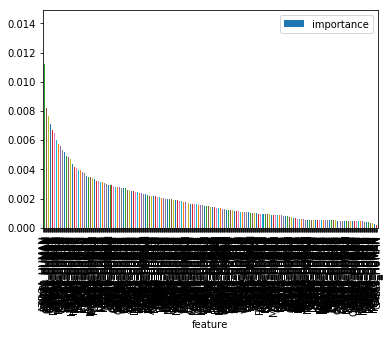

In [128]:
feature_rank[feature_rank['importance']>0].plot.bar(x='feature', y='importance', rot=90)

# Visualize the distribution of the most important feature identified by Random Forest

ATD3A_HUMAN


C:\Users\James\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


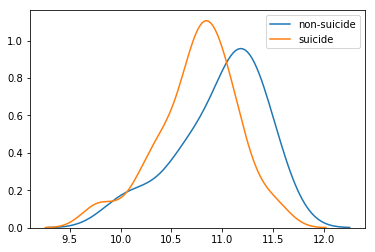

In [136]:
feature1 = feature_rank.iloc[0]['feature']
print(feature1)
sns.kdeplot(data[(data['suicide']==0)]['FGF9_HUMAN'],label='non-suicide')
sns.kdeplot(data[(data['suicide']==1)]['FGF9_HUMAN'],label='suicide')

# Run t-test to see which features are statistically significant between two groups

In [138]:
import scipy 

In [140]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)[1]
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

In [141]:
pvalues[pvalues['pvalues']<0.05/100]

,feature,pvalues
0,ATD3A_HUMAN,0.000067
7,CPNE1_HUMAN,0.000380
14,PRS8_HUMAN,0.000273
85,SYFA_HUMAN,0.000084


### Things done
Log adjustment to data
fill 0s by group, sex
nonparametric test - mann whiteney u. Can only be used for ordinal data(larger is significant) For each observation in one set, count the number of times this first value wins over any observation.